In [1]:
import re
import torch as pt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from functools import reduce
from matplotlib import rcParams

import src as sp
import runtime as rt
from theme import colors

# font parameters
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 12

## Monomer

In [2]:
# parameters
mode = "msa"
filepaths = {
    "wt": glob("benchmark_data/wt/monomers/*.pdb"),
    "carbonara_maxseqid": glob(f"benchmark_data/carbonara/monomers/maxseqid/alphafold_models_{mode}/*_rank_001_*.pdb"),
    "carbonara_minseqid": glob(f"benchmark_data/carbonara/monomers/minseqid/alphafold_models_{mode}/*_rank_001_*.pdb"),
    "carbonara_minseqsim": glob(f"benchmark_data/carbonara/monomers/minseqsim/alphafold_models_{mode}/*_rank_001_*.pdb"),
}
keys = ["carbonara_maxseqid", "carbonara_minseqid", "carbonara_minseqsim"]

# read structures 
structs = {}
for key in filepaths:
    structs[key] = {}
    for fp in filepaths[key]:
        sid = re.search(r'/([0-9A-Z]{4}(_[A-Z])?)', fp)[1]
        structs[key][sid] = sp.read_pdb(fp)

# evaluate structures 
results = []
for key in keys:
    for sid in structs[key]:
        if sid in structs["wt"]:
            # get structures pair
            struct_ref = structs["wt"][sid]
            struct = structs[key][sid]

            # get C_alpha coordinates
            xyz_ca_ref = pt.from_numpy(sp.atom_select(struct_ref, struct_ref['name'] == 'CA')['xyz'])
            xyz_ca = pt.from_numpy(sp.atom_select(struct, struct['name'] == 'CA')['xyz'])

            # size check
            struct_ca_ref = sp.atom_select(struct_ref, struct_ref['name'] == 'CA')
            struct_ca = sp.atom_select(struct, struct['name'] == 'CA')

            subs_ca = sp.split_by_chain(struct_ca)
            subs_ca_ref = sp.split_by_chain(struct_ca_ref)

            b_size = np.all([subs_ca[cid]['xyz'].shape[0] == subs_ca_ref[cid_ref]['xyz'].shape[0] for cid,cid_ref in zip(subs_ca, subs_ca_ref)])
        
            #if xyz_ca_ref.shape[0] == xyz_ca.shape[0]:
            if b_size:
                rmsd = sp.compute_rmsd(xyz_ca_ref, xyz_ca).item()
                lddt = pt.mean(rt.compute_lDDT(xyz_ca_ref, xyz_ca)).item()
                plddt = np.mean(sp.atom_select(struct, struct['name'] == 'CA')['bfactor'])

                results.append({
                    "method": key,
                    'sid': sid,
                    'rmsd': rmsd,
                    'lddt': lddt,
                    'plddt': plddt,
                    'size': xyz_ca.shape[0],
                })
            else:
                print(sid, xyz_ca_ref.shape[0], xyz_ca.shape[0])

# pack results
dfm = pd.DataFrame(results).sort_values(["sid", "method"])
dfm = dfm.groupby("sid").filter(lambda x: len(x)==len(keys))

# merge with tmscore
dfmtm = pd.read_csv("results/monomers_options_structure_msa_tmscore.csv")
#dfmtm = pd.read_csv("results/monomers_structure_ss_tmscore.csv")
dfm = pd.merge(dfm, dfmtm, on=['method', 'sid'])

# merge with sequence information
dfms = pd.read_csv("results/monomers_sequence_analysis.csv")
dfm = pd.merge(dfm, dfms, on=['method', 'sid'])

# save and display
#dfm.to_csv("results/monomers_structure_analysis.csv", index=False)
dfm

,method,sid,rmsd,lddt,plddt,size,tmscore,sequence_identity,sequence_similarity,len
0,carbonara_maxseqid,1ABO_A,0.853312,94.408073,93.450000,58,0.9391,0.637931,0.827586,58
1,carbonara_minseqid,1ABO_A,1.146718,91.421234,95.206379,58,0.9033,0.275862,0.724138,58
2,carbonara_minseqsim,1ABO_A,1.053467,92.155006,93.705000,58,0.9125,0.275862,0.551724,58
3,carbonara_maxseqid,1ABQ_A,1.029834,90.105614,94.648035,56,0.9192,0.482143,0.696429,56
4,carbonara_minseqid,1ABQ_A,1.256044,86.876358,87.322143,56,0.8755,0.142857,0.589286,56
...,...,...,...,...,...,...,...,...,...,...
340,carbonara_minseqid,6PNW_B,1.236366,93.044037,94.066935,62,0.0000,0.274194,0.596774,62
341,carbonara_minseqsim,6PNW_B,1.592222,91.209702,86.646774,62,0.0000,0.274194,0.290323,62
342,carbonara_maxseqid,6R3C_A,2.003090,80.777519,83.040503,159,0.8910,0.283019,0.484277,159
343,carbonara_minseqid,6R3C_A,2.350715,76.207588,73.692642,159,0.8298,0.081761,0.383648,159


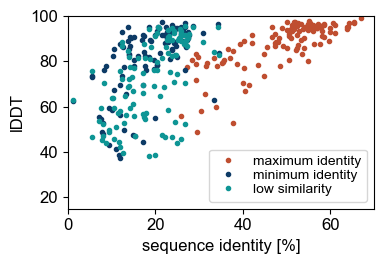

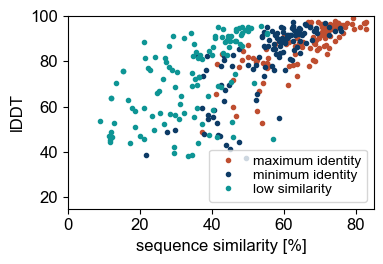

In [3]:
# parameters
keys = ["carbonara_maxseqid", "carbonara_minseqid", "carbonara_minseqsim"]
labels = ['maximum identity', 'minimum identity', 'low similarity']

# get data
y0 = 1e2*np.stack([dfm[dfm['method'] == key]['sequence_identity'].values for key in keys], axis=1)
y1 = 1e2*np.stack([dfm[dfm['method'] == key]['sequence_similarity'].values for key in keys], axis=1)
y2 = np.stack([dfm[dfm['method'] == key]['lddt'].values for key in keys], axis=1)

# plot
#plt.figure(figsize=(3,3))
plt.figure(figsize=(4,2.8))
for i in range(y0.shape[1]):
    plt.plot(y0[:,i], y2[:,i], '.', color=colors[i], label=labels[i])
plt.xlim(0, 70)
plt.ylim(15, 100)
plt.legend(loc='lower right', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('sequence identity [%]')
plt.ylabel('lDDT')
plt.tight_layout()
plt.savefig('graphs/af_options_lddt_sequence_identity.svg')
plt.show()

# plot
#plt.figure(figsize=(3,3))
plt.figure(figsize=(4,2.8))
for i in range(y0.shape[1]):
    plt.plot(y1[:,i], y2[:,i], '.', color=colors[i], label=labels[i])
plt.xlim(0, 85)
plt.ylim(15, 100)
plt.legend(loc='lower right', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('sequence similarity [%]')
plt.ylabel('lDDT')
plt.tight_layout()
plt.savefig('graphs/af_options_lddt_sequence_similarity.svg')
plt.show()

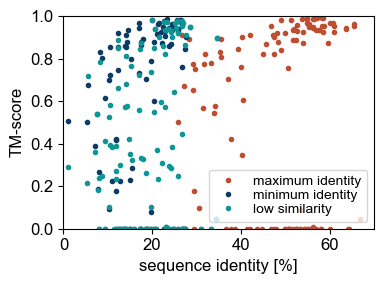

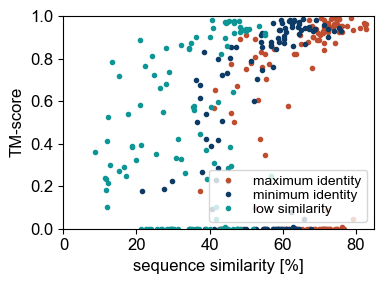

In [4]:
# parameters
keys = ["carbonara_maxseqid", "carbonara_minseqid", "carbonara_minseqsim"]
labels = ['maximum identity', 'minimum identity', 'low similarity']

# get data
y0 = 1e2*np.stack([dfm[dfm['method'] == key]['sequence_identity'].values for key in keys], axis=1)
y1 = 1e2*np.stack([dfm[dfm['method'] == key]['sequence_similarity'].values for key in keys], axis=1)
y2 = np.stack([dfm[dfm['method'] == key]['tmscore'].values for key in keys], axis=1)

# plot
plt.figure(figsize=(4,3))
for i in range(y0.shape[1]):
    plt.plot(y0[:,i], y2[:,i], '.', color=colors[i], label=labels[i])
plt.xlim(0, 70)
plt.ylim(0.0, 1.0)
plt.legend(loc='lower right', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('sequence identity [%]')
plt.ylabel('TM-score')
plt.tight_layout()
#plt.savefig('graphs/af_validation_sequence_identity.svg')
plt.show()

# plot
plt.figure(figsize=(4,3))
for i in range(y0.shape[1]):
    plt.plot(y1[:,i], y2[:,i], '.', color=colors[i], label=labels[i])
plt.xlim(0, 85)
plt.ylim(0.0, 1.0)
plt.legend(loc='lower right', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('sequence similarity [%]')
plt.ylabel('TM-score')
plt.tight_layout()
#plt.savefig('graphs/af_validation_sequence_similarity.svg')
plt.show()

In [5]:
dfb = pd.read_csv("results/monomers_sequence_evalue.csv")
dfb = pd.merge(dfm, dfb, on=["method", "sid"], how='outer').dropna(subset='plddt')
dfb = dfb[dfb['method'].isin(["carbonara_minseqid", "carbonara_minseqsim"])]
dfb

,method,sid,rmsd,lddt,plddt,size,tmscore,sequence_identity,sequence_similarity,len,evalue
1,carbonara_minseqid,1ABO_A,1.146718,91.421234,95.206379,58.0,0.9033,0.275862,0.724138,58.0,6.450000e-09
2,carbonara_minseqsim,1ABO_A,1.053467,92.155006,93.705000,58.0,0.9125,0.275862,0.551724,58.0,4.960000e-04
4,carbonara_minseqid,1ABQ_A,1.256044,86.876358,87.322143,56.0,0.8755,0.142857,0.589286,56.0,3.700000e-02
5,carbonara_minseqsim,1ABQ_A,10.907299,59.366417,61.608750,56.0,0.5765,0.142857,0.357143,56.0,2.700000e+00
7,carbonara_minseqid,1AWO_A,5.603491,55.501415,49.747018,57.0,0.3873,0.070175,0.403509,57.0,1.600000e+00
...,...,...,...,...,...,...,...,...,...,...,...
338,carbonara_minseqsim,6PNW_A,1.590276,90.330750,86.433226,62.0,0.8624,0.274194,0.322581,62.0,9.530000e-05
340,carbonara_minseqid,6PNW_B,1.236366,93.044037,94.066935,62.0,0.0000,0.274194,0.596774,62.0,1.010000e-07
341,carbonara_minseqsim,6PNW_B,1.592222,91.209702,86.646774,62.0,0.0000,0.274194,0.290323,62.0,1.000000e-03
343,carbonara_minseqid,6R3C_A,2.350715,76.207588,73.692642,159.0,0.8298,0.081761,0.383648,159.0,1.630000e-06


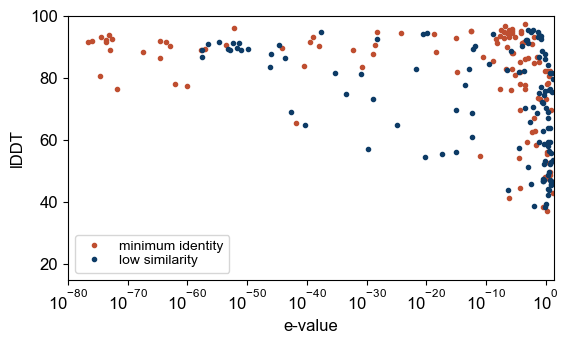

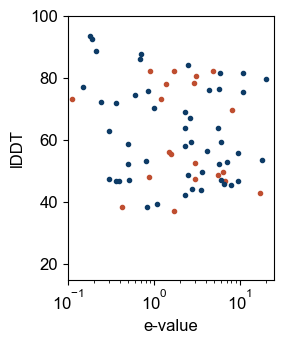

In [18]:
# parameters
keys = ["carbonara_minseqid", "carbonara_minseqsim"]
labels = ['minimum identity', 'low similarity']

# get data
y0_l = [dfb[dfb['method'] == key]['evalue'].values for key in keys]
y1_l = [dfb[dfb['method'] == key]['lddt'].values for key in keys]

# plot
plt.figure(figsize=(5.8,3.6))
for i in range(len(y0_l)):
    plt.semilogx(y0_l[i], y1_l[i], '.', color=colors[i], label=labels[i])
plt.xlim(1e-80, 25)
plt.ylim(15, 100)
plt.legend(loc='lower left', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('e-value')
plt.ylabel('lDDT')
plt.tight_layout()
plt.savefig('graphs/af_options_lddt_evalue.svg')
plt.show()

# plot
plt.figure(figsize=(3,3.6))
for i in range(len(y0_l)):
    plt.semilogx(y0_l[i], y1_l[i], '.', color=colors[i], label=labels[i])
plt.xlim(1e-1, 25)
plt.ylim(15, 100)
#plt.legend(loc='lower left', prop={'size': 10}, labelspacing=0.1)
plt.xlabel('e-value')
plt.ylabel('lDDT')
plt.tight_layout()
plt.savefig('graphs/af_options_lddt_evalue_zoom.svg')
plt.show()

## Dimer

In [ ]:
# parameters
mode = "msa"
filepaths = {
    "wt": glob("benchmark_data/wt/dimers/*.pdb"),
    "carbonara_maxseqid": glob(f"benchmark_data/carbonara/dimers/maxseqid/alphafold_models_{mode}/*_rank_001_*.pdb"),
    "carbonara_minseqid": glob(f"benchmark_data/carbonara/dimers/minseqid/alphafold_models_{mode}/*_rank_001_*.pdb"),
    "carbonara_minseqsim": glob(f"benchmark_data/carbonara/dimers/minseqsim/alphafold_models_{mode}/*_rank_001_*.pdb"),
}
keys = ["carbonara_maxseqid", "carbonara_minseqid", "carbonara_minseqsim"]

# read structures 
structs = {}
for key in filepaths:
    structs[key] = {}
    for fp in filepaths[key]:
        sid = re.search(r'/([0-9A-Z]{4}(_[A-Z])?)', fp)[1]
        structs[key][sid] = sp.read_pdb(fp)

# evaluate structures 
results = []
for key in keys:
    for sid in structs[key]:
        pdbid = sid.split('_')[0]
        if pdbid in structs["wt"]:
            # get structures pair
            struct_ref = structs["wt"][pdbid]
            struct = structs[key][sid]

            # size check
            struct_ca_ref = sp.atom_select(struct_ref, struct_ref['name'] == 'CA')
            struct_ca = sp.atom_select(struct, struct['name'] == 'CA')

            # check size
            subs_ca = sp.split_by_chain(struct_ca)
            #subs_ca_ref = sp.split_by_chain(struct_ca_ref)

            # get C_alpha coordinates
            xyz_ca_ref = pt.from_numpy(struct_ca_ref['xyz'])
            
            # find chain order
            xyz_ca_l = [
                pt.from_numpy(sp.concatenate_chains({cid:subs_ca[cid] for cid in subs_ca})['xyz']),
                pt.from_numpy(sp.concatenate_chains({cid:subs_ca[cid] for cid in reversed(subs_ca)})['xyz']),
            ]
            iord = np.argmin([sp.compute_rmsd(xyz_ca_ref, xyz_ca).item() for xyz_ca in xyz_ca_l])
            
            # compute scores
            rmsd = sp.compute_rmsd(xyz_ca_ref, xyz_ca_l[iord]).item()
            lddt = pt.mean(rt.compute_lDDT(xyz_ca_ref, xyz_ca_l[iord])).item()
            plddt = np.mean(sp.atom_select(struct, struct['name'] == 'CA')['bfactor'])

            # store results
            results.append({
                "method": key,
                'sid': sid,
                'rmsd': rmsd,
                'lddt': lddt,
                'plddt': plddt,
                'size': xyz_ca.shape[0],
            })

# pack results
dfd = pd.DataFrame(results).sort_values(["sid", "method"])
dfd = dfd.groupby("sid").filter(lambda x: len(x)==len(keys))

# merge with tmscore
dfdtm = pd.read_csv("results/dimers_options_structure_msa_tmscore.csv")
#dfdtm = pd.read_csv("results/dimers_structure_ss_tmscore.csv")
dfd = pd.merge(dfd, dfdtm, on=['method', 'sid'])

# merge with sequence information
dfds = pd.read_csv("results/dimers_sequence_analysis.csv")
dfd = pd.merge(dfd, dfds, on=['method', 'sid'])

# save and display
#dfd.to_csv("results/dimers_structure_analysis.csv", index=False)
dfd

In [ ]:
# parameters
keys = ["carbonara_maxseqid", "carbonara_minseqid", "carbonara_minseqsim"]
labels = ['maximum identity', 'minimum identity', 'low similarity']

# get data
y0 = 1e2*np.stack([dfd[dfd['method'] == key]['sequence_identity'].values for key in keys], axis=1)
y1 = 1e2*np.stack([dfd[dfd['method'] == key]['sequence_similarity'].values for key in keys], axis=1)
y2 = np.stack([dfd[dfd['method'] == key]['lddt'].values for key in keys], axis=1)

# plot
plt.figure(figsize=(4,3))
for i in range(y0.shape[1]):
    plt.plot(y0[:,i], y2[:,i], '.', color=colors[i], label=labels[i])
plt.xlim(0, 70)
plt.ylim(12, 100)
plt.legend(loc='lower right', prop={'size': 8}, labelspacing=0.1)
plt.xlabel('sequence identity [%]')
plt.ylabel('lDDT')
plt.tight_layout()
#plt.savefig('graphs/af_validation_sequence_identity.svg')
plt.show()

# plot
plt.figure(figsize=(4,3))
for i in range(y0.shape[1]):
    plt.plot(y1[:,i], y2[:,i], '.', color=colors[i], label=labels[i])
plt.xlim(0, 85)
plt.ylim(12, 100)
plt.legend(loc='lower right', prop={'size': 8}, labelspacing=0.1)
plt.xlabel('sequence similarity [%]')
plt.ylabel('lDDT')
plt.tight_layout()
#plt.savefig('graphs/af_validation_sequence_similarity.svg')
plt.show()

In [ ]:
# parameters
keys = ["carbonara_maxseqid", "carbonara_minseqid", "carbonara_minseqsim"]
labels = ['maximum identity', 'minimum identity', 'low similarity']

# get data
y0 = 1e2*np.stack([dfd[dfd['method'] == key]['sequence_identity'].values for key in keys], axis=1)
y1 = 1e2*np.stack([dfd[dfd['method'] == key]['sequence_similarity'].values for key in keys], axis=1)
y2 = np.stack([dfd[dfd['method'] == key]['tmscore'].values for key in keys], axis=1)

# plot
plt.figure(figsize=(4,3))
for i in range(y0.shape[1]):
    plt.plot(y0[:,i], y2[:,i], '.', color=colors[i], label=labels[i])
plt.xlim(0, 70)
plt.ylim(0.0, 1.0)
plt.legend(loc='lower right', prop={'size': 8}, labelspacing=0.1)
plt.xlabel('sequence identity [%]')
plt.ylabel('lDDT')
plt.tight_layout()
#plt.savefig('graphs/af_validation_sequence_identity.svg')
plt.show()

# plot
plt.figure(figsize=(4,3))
for i in range(y0.shape[1]):
    plt.plot(y1[:,i], y2[:,i], '.', color=colors[i], label=labels[i])
plt.xlim(0, 85)
plt.ylim(0.0, 1.0)
plt.legend(loc='lower right', prop={'size': 8}, labelspacing=0.1)
plt.xlabel('sequence similarity [%]')
plt.ylabel('lDDT')
plt.tight_layout()
#plt.savefig('graphs/af_validation_sequence_similarity.svg')
plt.show()